<h1>Implementing Products Detection</h1>
Let's implement packs detection using our model. For the sake of simplicity copy frozen graph (the result of previous step) to pack_detector_fg folder. If you don't have good graph, you can use mine. Please, note that your training and evaluation images are different than mine.

In [1]:
import numpy as np
import tensorflow as tf
import cv2
# import pandas as pd

from collections import defaultdict
from matplotlib import pyplot as plt

# This is needed since the notebook is stored in the object_detection folder.
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

if tf.__version__ < '1.4.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

D:\dev\tensorflow_SSD_Mobilenet\object_detection\utils\visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "c:\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\python\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\python\python36\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\python\python36\lib\site-pack

In [2]:
# This is needed to display the images.
%matplotlib inline

In [3]:
# paths to main folders: with frozen graph, with classes labels, 
# with all shelves images and with data
PATH_TO_MODEL = 'output/philmor200k.pb'
PATH_TO_LABELS = 'maps/philmor48.pbtxt'
PATH_TO_IMAGES = 'test_images/PhM_test/'
PATH_TO_DATA = 'data/'
NUM_CLASSES = 48

In [4]:
# load photos dataframe to get all evaluation images names
photos = pd.read_pickle(f'{PATH_TO_DATA}photos.pkl')
photos = photos[~photos.is_train]
photos.head()

NameError: name 'pd' is not defined

In [5]:
# load frozen graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [6]:
# load categories (we have only 1 category pack)
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
# let's write function that executes detection
def run_inference_for_single_image(image, image_tensor, sess, tensor_dict):
    # Run inference
    expanded_dims = np.expand_dims(image, 0)
    output_dict = sess.run(tensor_dict, feed_dict={image_tensor: expanded_dims})
    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    return output_dict

In [8]:
# it is useful to be able to run inference not only on the whole image,
# but also on its parts
# cutoff - minimum detection scrore needed to take box
def run_inference_for_image_part(image_tensor, sess, tensor_dict, 
                                 image, cutoff, ax0, ay0, ax1, ay1):
    boxes = []
    im = image[ay0:ay1, ax0:ax1]
    h, w, c = im.shape
    output_dict = run_inference_for_single_image(im, image_tensor, sess, tensor_dict)
    for i in range(100):
        if output_dict['detection_scores'][i] < cutoff:
            break
        y0, x0, y1, x1, score = *output_dict['detection_boxes'][i], \
                                output_dict['detection_scores'][i]
        x0, y0, x1, y1, score = int(x0*w), int(y0*h), \
                                int(x1*w), int(y1*h), \
                                int(score * 100)
        boxes.append((x0+ax0, y0+ay0, x1+ax0, y1+ay0, score))
    return boxes

In [9]:
# additional helper function to work not with coordinates but with percents
def run_inference_for_image_part_pcnt(image_tensor, sess, tensor_dict, 
                                 image, cutoff, p_ax0, p_ay0, p_ax1, p_ay1):
    h, w, c = image.shape
    max_x, max_y = w-1, h-1
    return run_inference_for_image_part(
                                image_tensor, sess, tensor_dict, 
                                image, cutoff, 
                                int(p_ax0*max_x), int(p_ay0*max_y), 
                                int(p_ax1*max_x), int(p_ay1*max_y))

In [10]:
# function to display image with bounding boxes
def display_image_with_boxes(image, boxes, p_x0=0, p_y0=0, p_x1=1, p_y1=1):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for x0, y0, x1, y1, score in boxes:
        image = cv2.rectangle(image, (x0, y0), (x1, y1), (0,255,0), 5)
    if p_x0 != 0 or p_y0 !=0 or p_x1 != 1 or p_y1 != 1:
        h, w, c = image.shape
        max_x, max_y = w-1, h-1
        image = cv2.rectangle(image, 
                              (int(p_x0*max_x), int(p_y0*max_y)), 
                              (int(p_x1*max_x), int(p_y1*max_y)), (0,0,255), 5)
    plt.figure(figsize=(14, 14))
    plt.imshow(image)

In [ ]:
def display_image_with_boxes_viz_utils(image, boxes, p_x0=0, p_y0=0, p_x1=1, p_y1=1):

In [11]:
# initializations function
def initialize_graph():
    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name
                        for op in ops
                        for output in op.outputs}
    tensor_dict = {}
    for key in ['num_detections', 'detection_boxes',
                'detection_scores', 'detection_classes',
                'detection_masks']:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
    return image_tensor, tensor_dict

# starting function for inference
def do_inference_and_display(file, cutoff, p_x0=0, p_y0=0, p_x1=1, p_y1=1):
    with detection_graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 0.4
        with tf.Session(config=config) as sess:
            image_tensor, tensor_dict = initialize_graph()
            image = cv2.imread(f'{PATH_TO_IMAGES}{file}')
            h, w, c = image.shape
            boxes = run_inference_for_image_part_pcnt(
                image_tensor, sess, tensor_dict, image, cutoff, p_x0, p_y0, p_x1, p_y1)
            display_image_with_boxes(image, boxes, p_x0, p_y0, p_x1, p_y1)


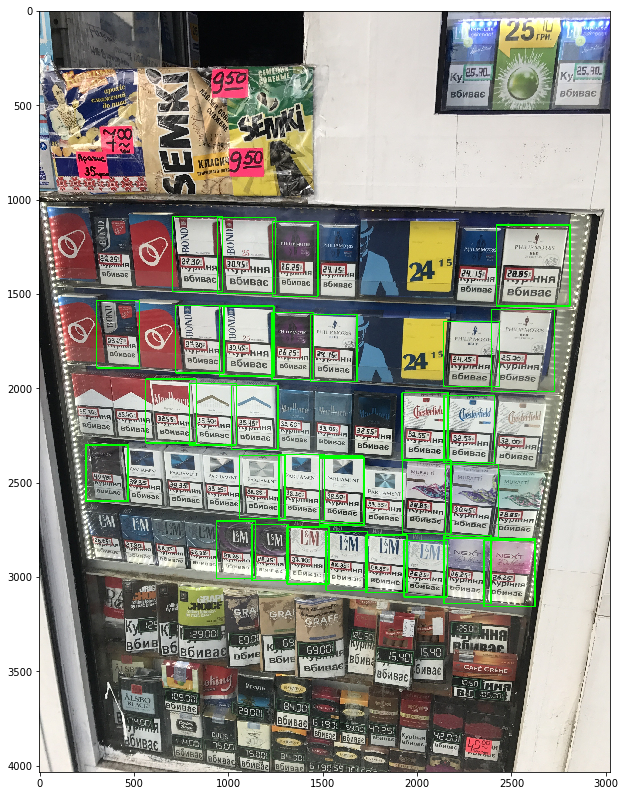

In [14]:
# to save time let's start with really hard image
do_inference_and_display('IMG_0136.JPG', 0.1)
# do_inference_and_display('IMG_0417.JPG', 0.1)
# it works not bad, but not with 100% quality

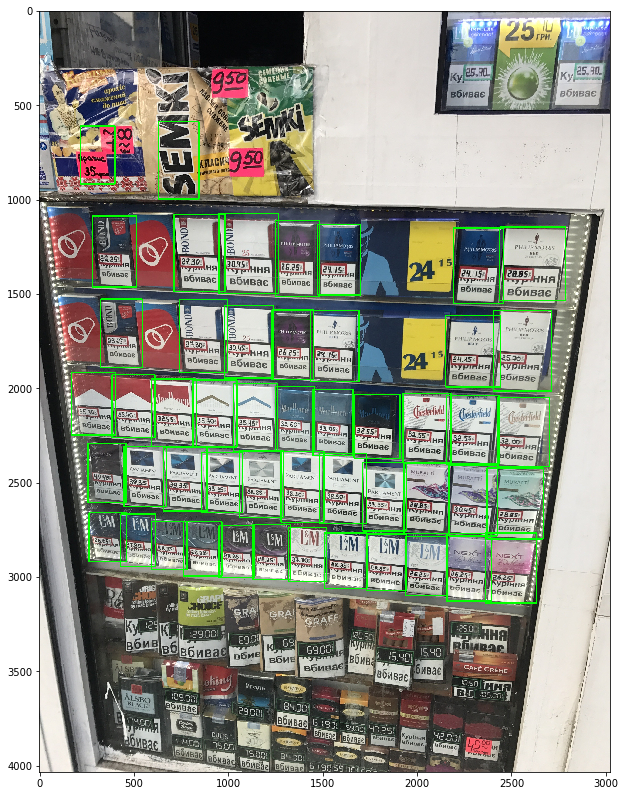

In [12]:
# we can try to reduce cutoff rate to include more boxes
do_inference_and_display('IMG_0136.JPG', 0.1)
#do_inference_and_display('IMG_0417.JPG', 0.4)
# it gives better result but also gives some false positive

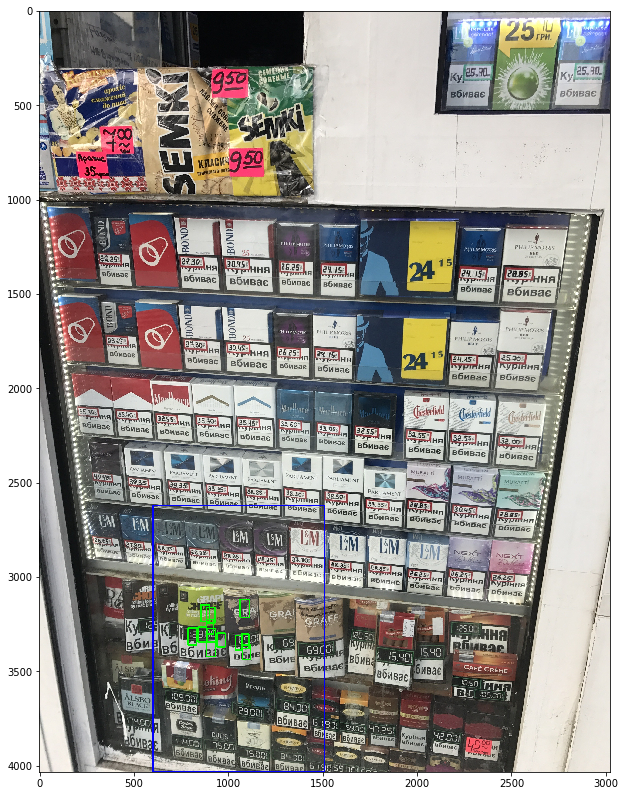

In [13]:
# let's try do detection on small part of image
# let's also increase the cutoff rate
do_inference_and_display('IMG_0136.JPG', 0.1, 0.2, 0.65, 0.5, 1)
# it works perfect for small parts of image, it gives an idea for
# sliding window approach

In [16]:
def do_sliding_window_inference(file, cutoff):
    with detection_graph.as_default():
        with tf.Session() as sess:
            image_tensor, tensor_dict = initialize_graph()
            image = cv2.imread(f'{PATH_TO_IMAGES}{file}')
            h, w, c = image.shape
            boxes = run_inference_for_image_part_pcnt(
                image_tensor, sess, tensor_dict, image, cutoff, 0, 0, 1, 1)
            a = np.array(boxes)
#             print(a)
            mean_dx = int(np.mean(a[:,2]-a[:,0]))
            mean_dy = int(np.mean(a[:,3]-a[:,1]))
            step_x, step_y = mean_dx, mean_dy
            window_size = 10*mean_dy
#             print(window_size)
            boxes = []
            y0 = 0
            while y0 < h-1:
                x0 = 0
                while x0 < w-1:
                    x1, y1 = x0 + window_size, y0 + window_size
#                     print(x1,y1)
                    boxes += run_inference_for_image_part(
                        image_tensor, sess, tensor_dict, image, cutoff, 
                        x0, y0, x1, y1)
                    x0 += step_y
                y0 += step_x
            display_image_with_boxes(image, boxes)

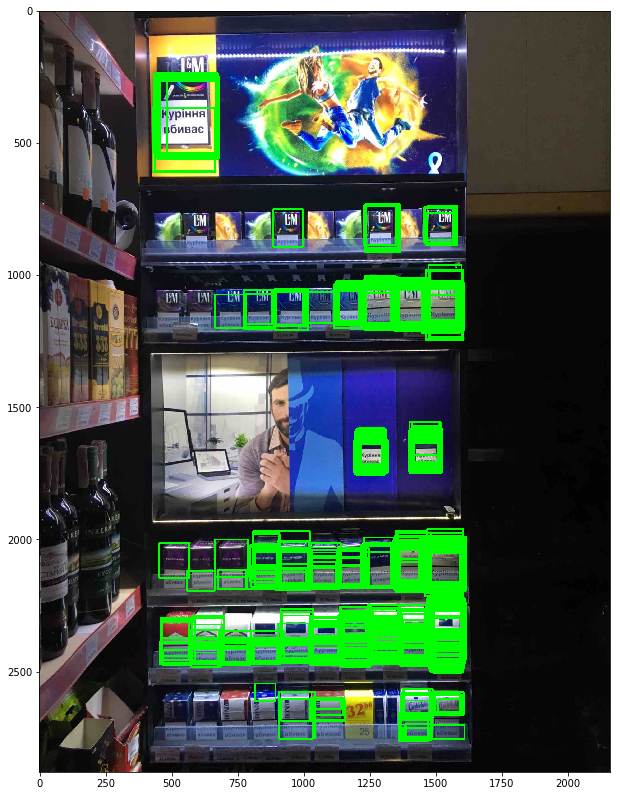

In [17]:
do_sliding_window_inference('14.JPG', 0.8)
# do_sliding_window_inference('IMG_0417.JPG', 0.1)
# it captures all packs, but we also have a lot of the same pack detections
# we need non-maximum suppression

In [18]:
# function for non-maximum suppression
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return np.array([]).astype("int")

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    sc = boxes[:,4]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(sc)
 
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        #todo fix overlap-contains...
        overlap = (w * h) / area[idxs[:last]]
         
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    
    return boxes[pick].astype("int")

In [56]:
# main function to 
def do_sliding_window_inference_with_nm_suppression(file, cutoff):
    with detection_graph.as_default():
        with tf.Session() as sess:
            image_tensor, tensor_dict = initialize_graph()
            image = cv2.imread(f'{PATH_TO_IMAGES}{file}')
            h, w, c = image.shape
            boxes = run_inference_for_image_part_pcnt(
                image_tensor, sess, tensor_dict, image, cutoff, 0, 0, 1, 1)
            a = np.array(boxes)
            mean_dx = int(np.mean(a[:,2]-a[:,0]))
            mean_dy = int(np.mean(a[:,3]-a[:,1]))
            step_x, step_y = mean_dx, mean_dy
            window_size = 7*mean_dy
            boxes = []
            y0 = 0
            while y0 < h-1:
                x0 = 0
                while x0 < w-1:
                    x1, y1 = x0 + window_size, y0 + window_size
                    boxes += run_inference_for_image_part(
                        image_tensor, sess, tensor_dict, image, cutoff, 
                        x0, y0, x1, y1)
                    x0 += step_y
                y0 += step_x
            boxes = non_max_suppression(np.array(boxes), 0.4)
            display_image_with_boxes(image, boxes)

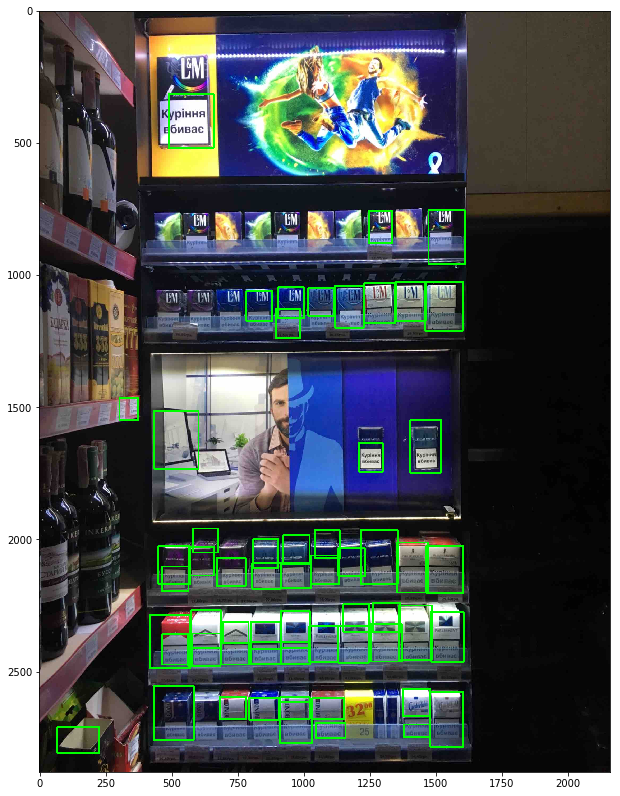

In [57]:
do_sliding_window_inference_with_nm_suppression('14.JPG', 0.1)
# it gives perfect result

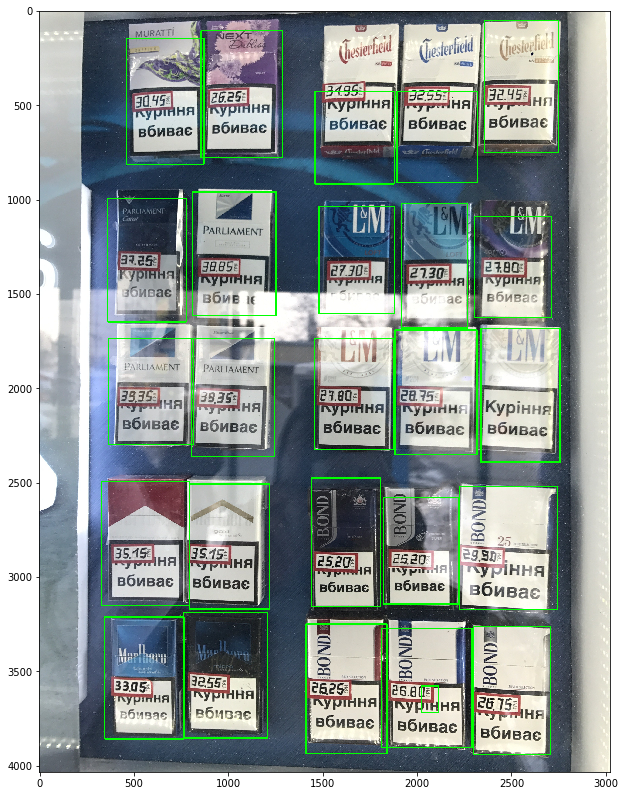

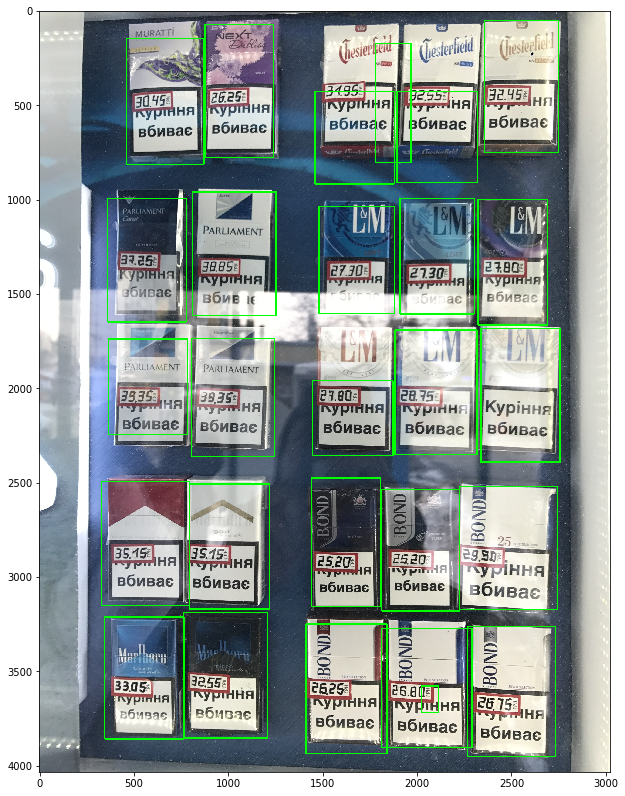

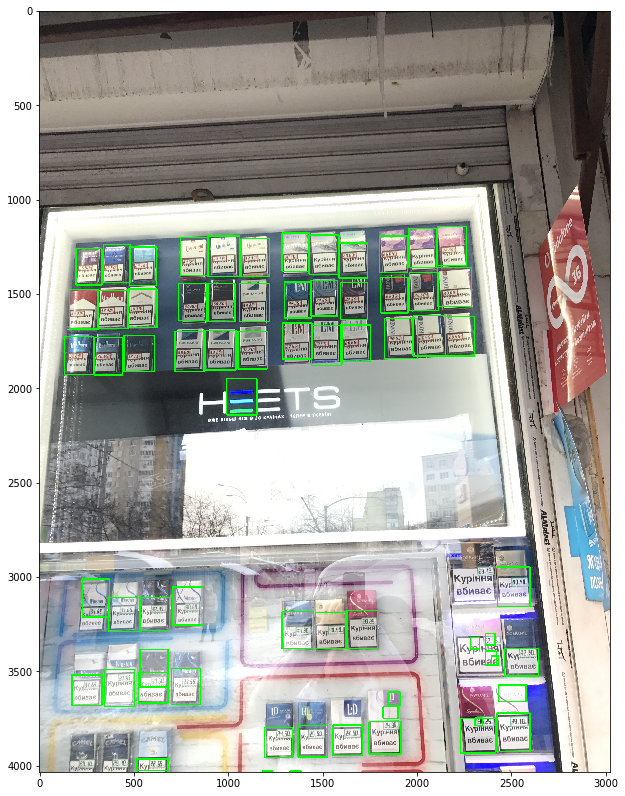

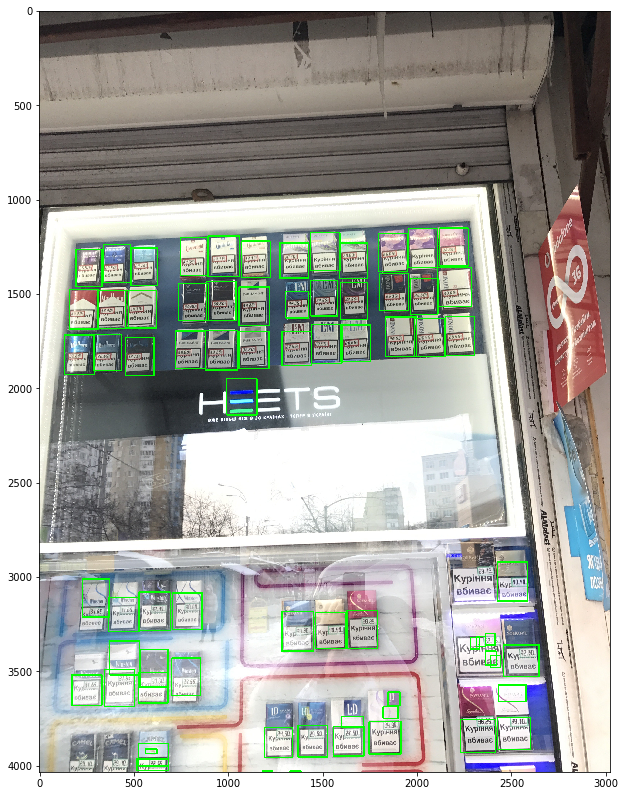

In [108]:
# some more examples
do_sliding_window_inference_with_nm_suppression('IMG_0214.JPG', 0.6)
do_sliding_window_inference_with_nm_suppression('IMG_0214.JPG', 0.3)
do_sliding_window_inference_with_nm_suppression('IMG_0198.JPG', 0.6) # note 0.5!!!
do_sliding_window_inference_with_nm_suppression('IMG_0198.JPG', 0.3)